In [1]:
from hamilton_ice.pipeline import get_func_args, object_io_nodes, build_pipeline
from hamilton_ice.io.artifact import artifact
from hamilton_ice.io.pandas import pandas_csv_source, pandas_msgpack
from hamilton_ice.io.dummy import dummy
from hamilton_ice.util.graphviz import dag_plot
import pandas as pd
import numpy as np
import random
import torch
from dataclasses import dataclass
from hamilton_ice.util.graphviz import dag_plot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Questions
* Use overrides instead of partial results
* Feature engineering is shared through module
* How to seperate code into docker containers for pyspark and pytorch
    * @config.when
    * module separation
    * all in one
* Rerun the dag for each epoch

# Misc DataClass Code
These are used to describe shapes for more complex composite datastructures that contain config, combinations of training/validation data, or loss metrics.

In [2]:
# We maintain a small holdout set of data for validation purposes.
# I was pretty sloppy with this, it's not randomized properly, and it's 
# small and very noisy. I had a much better version of this that I can recreate later.
validation = None

# This is a singular config object that's 
# used for any free parameter we wish to control 
# within the training/serving pipeline.  In prod it could be sealed.
@dataclass
class Config:
    observed_size = 0
    reservoir_size = 50
    random_seed = 42
    output_field = "Survived"

# Since everything is streaming in this approach, we can generate both training and validation
# minibatches on the fly.  This dataclass clearly specifies them both as they are chunked
# out of the data.
@dataclass
class TrainingValidationMinibatch:
    train : pd.DataFrame
    validation : pd.DataFrame
        
# Ditto for metrics on the minibatch metrics
@dataclass
class AnnotatedLoss:
    loss : float
    validation_loss : float


In [3]:
# Simple Titanic
# This is a simple class interface that generates raw minibatches from a source.
# The source function just needs to return a url/file location to pull chunked CSV records from.
class Titanic:
    @artifact
    def params():
        return {}
    
    @artifact
    def config():
        return Config()
    
    @pandas_csv_source
    def minibatch(config):
        return "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"    

# We can build the pipeline so that we can use the generators
build_pipeline(Titanic)        

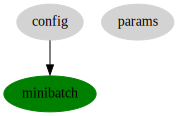

In [4]:
# Not much to see here on the DAG plot.  We pass config into minibatch. 
# There's an extra params node that's not used but required by the code.
# I was too lazy to remove it here, just ignore it.
dag_plot(Titanic)

In [5]:
# Let's look at a sample of the raw data from the generator, it's a pandas dataframe.
next(Titanic.minibatch.generator())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
# We can continue to build on the Titanic DAG.
# This time by adding functions useful for normalization.
class TitanicNormalized(Titanic):       
    @dummy
    def normalized_data(minibatch, config):
        dat = minibatch
        normalized = pd.DataFrame({
            "Survived" : dat["Survived"].astype(float),
            "NormPclass" : dat["Pclass"]/3,
            "MaleSex" : (dat["Sex"] == "male").astype(float),
            "FemaleSex" : (dat["Sex"] == "female").astype(float),
            "NormAge" : dat["Age"] / 100,
            "NormSibSp" :dat["SibSp"] /10,
            "NormParch" : dat["Parch"]/10,
            "NormFare" : dat["Fare"]/1000,
            "Embarked_C" : (dat["Embarked"] == "C").astype(float),
            "Embarked_S" : (dat["Embarked"] == "S").astype(float),
            "Embarked_Q" : (dat["Embarked"] == "Q").astype(float),
        })
        mean_value = normalized["NormAge"].mean(skipna=True)
        normalized["NormAge"].fillna(mean_value, inplace=True)
        yield normalized
    
    @dummy
    def annotated_data(normalized_data, config):
#         np.random.seed(config.random_seed)
        msk = np.random.rand(len(normalized_data)) < 0.8
        normalized_data["train"] = msk
        normalized_data["eval"] = ~msk
        yield normalized_data

build_pipeline(TitanicNormalized)  

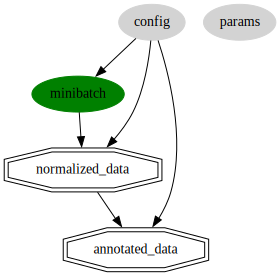

In [7]:
dag_plot(TitanicNormalized)

In [8]:
# Here's the normalized step. All the values are between 0 and 1 here.  
# (We can do better norms I know)
gen = TitanicNormalized.normalized_data.generator() 

In [9]:
for i in range(10):
    print(next(gen).tail(1))

    Survived  NormPclass  MaleSex  FemaleSex  NormAge  NormSibSp  NormParch   
31       1.0    0.333333      0.0        1.0   0.2772        0.1        0.0  \

    NormFare  Embarked_C  Embarked_S  Embarked_Q  
31  0.146521         1.0         0.0         0.0  
    Survived  NormPclass  MaleSex  FemaleSex  NormAge  NormSibSp  NormParch   
63       0.0         1.0      1.0        0.0     0.04        0.3        0.2  \

    NormFare  Embarked_C  Embarked_S  Embarked_Q  
63    0.0279         0.0         1.0         0.0  
    Survived  NormPclass  MaleSex  FemaleSex   NormAge  NormSibSp  NormParch   
95       0.0         1.0      1.0        0.0  0.258332        0.0        0.0  \

    NormFare  Embarked_C  Embarked_S  Embarked_Q  
95   0.00805         0.0         1.0         0.0  
     Survived  NormPclass  MaleSex  FemaleSex  NormAge  NormSibSp  NormParch   
127       1.0         1.0      1.0        0.0     0.24        0.0        0.0  \

     NormFare  Embarked_C  Embarked_S  Embarked_Q  
12

In [10]:
gen

<generator object build_generator.<locals>.generator at 0x106b82bc0>

In [11]:
# Here we are adding "train" and "eval" flags for each record in the chunked iterator.
# Note that we lock the random seed to ensure these are the same each run.
next(TitanicNormalized.annotated_data.generator()).head().iloc[:,-5:]

,Embarked_C,Embarked_S,Embarked_Q,train,eval
0,0.0,1.0,0.0,True,False
1,1.0,0.0,0.0,True,False
2,0.0,1.0,0.0,True,False
3,0.0,1.0,0.0,True,False
4,0.0,1.0,0.0,True,False


In [12]:
validation

In [13]:
# This DAG adds in annotated training phase that generates training and validation minibatches
class TitanicAnnotated(TitanicNormalized):        
    @dummy    
    def evaluate(annotated_data):  
        yield annotated_data[annotated_data["eval"]]
    
    
    @dummy                                 
    def annotated_train(annotated_data, config):
        train = annotated_data[annotated_data["train"]].drop(["train", "eval"], axis = 1).copy()
        
        global validation
        
        k = random.randint(0, config.reservoir_size)
        if validation is None:
            validation = train.copy()
        else:
            # swap an element with reservoir
            val_idx = random.choice(validation.index)
            train_idx = random.choice(train.index)
            print("swap", val_idx, train_idx)
            validation.loc[val_idx] = train.loc[train_idx]
            print(validation['Survived'].sum())

        yield TrainingValidationMinibatch(train=train, validation=validation)
        
build_pipeline(TitanicAnnotated)

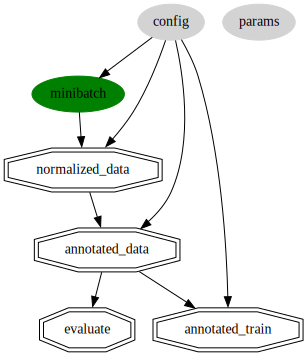

In [14]:
dag_plot(TitanicAnnotated)

In [15]:
# Here we are peeking into the train/validation minibatches. 
# Initially the validation minibatch will look identical, but later on it will contain samples
# across the epoch.

tv = next(TitanicAnnotated.annotated_train.generator())
print("TRAIN:\n")
print(tv.train.head())
print("\nVALIDATE:\n")
print(tv.validation.head())

TRAIN:

   Survived  NormPclass  MaleSex  FemaleSex  NormAge  NormSibSp  NormParch   
0       0.0    1.000000      1.0        0.0     0.22        0.1        0.0  \
1       1.0    0.333333      0.0        1.0     0.38        0.1        0.0   
3       1.0    0.333333      0.0        1.0     0.35        0.1        0.0   
4       0.0    1.000000      1.0        0.0     0.35        0.0        0.0   
6       0.0    0.333333      1.0        0.0     0.54        0.0        0.0   

   NormFare  Embarked_C  Embarked_S  Embarked_Q  
0  0.007250         0.0         1.0         0.0  
1  0.071283         1.0         0.0         0.0  
3  0.053100         0.0         1.0         0.0  
4  0.008050         0.0         1.0         0.0  
6  0.051862         0.0         1.0         0.0  

VALIDATE:

   Survived  NormPclass  MaleSex  FemaleSex  NormAge  NormSibSp  NormParch   
0       0.0    1.000000      1.0        0.0     0.22        0.1        0.0  \
1       1.0    0.333333      0.0        1.0     0.38   

In [16]:
i = 1

In [17]:
# This DAG will contain the config for the model, and use the upstream annotated 
# minibatches for trainining the model.

class TitanicTrain(TitanicAnnotated):
    @artifact
    def optimizer(model):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
        return optimizer
    
    @artifact
    def criterion(config):
        return torch.nn.BCELoss() 
    
    @dummy
    def train(annotated_train, model, optimizer, criterion):
        optimizer.zero_grad()
        train = annotated_train.train.drop(["Survived"], axis=1).to_numpy()
        train_features = torch.tensor(train)
        train_outputs = model(train_features.float())
        train_labels = torch.tensor(annotated_train.train["Survived"].to_numpy())

        validation = annotated_train.validation.drop(["Survived"], axis=1).to_numpy()
        validation_features = torch.tensor(validation)
        validation_outputs = model(validation_features.float())
        validation_labels = torch.tensor(annotated_train.validation["Survived"].to_numpy())
        loss = criterion(
            train_outputs.flatten().float(), 
            train_labels.flatten().float()
            )

        validation_loss = criterion(
            validation_outputs.flatten().float(), 
            validation_labels.flatten().float()
            )

        loss.backward() 
        optimizer.step()
        global i
        i += 1
        print('training', i)
      
        yield AnnotatedLoss(loss = loss.item(), validation_loss = validation_loss.item())
    
    @artifact
    def model (config, annotated_train):
        n_features = annotated_train.train.drop(["Survived"], axis=1).shape[1]
        model = torch.nn.Sequential(torch.nn.Linear(n_features, 50),
                            torch.nn.ReLU(),
                            torch.nn.Linear(50, 1),
                            torch.nn.Sigmoid())
        return model
        
build_pipeline(TitanicTrain)

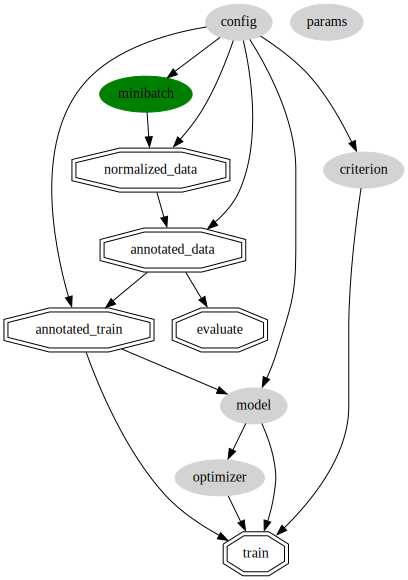

In [18]:
dag_plot(TitanicTrain)

In [19]:
# Here's a dead simple training loop.  
# This easily be abstracted away with an additional feature/service, but it's
# easy enough to follow along here.
epochs = []
for epoch in range(0,200):
    if epoch % 100 == 0:
        print(f"epoch: {epoch}")
    epoch = []
    for aloss in TitanicTrain.train.generator():
        epoch.append(aloss.__dict__)
    epoch = pd.DataFrame.from_records(epoch)
    epochs.append(epoch.mean())

epoch: 0
swap 16 7
12.0
swap 19 31
12.0
training 2
swap 11 37
11.0
training 3
swap 13 83
11.0
training 4
swap 7 116
11.0
training 5
swap 3 146
11.0
training 6
swap 15 176
10.0
training 7
swap 16 202
10.0
training 8
swap 24 253
10.0
training 9
swap 13 271
11.0
training 10
swap 24 300
12.0
training 11
swap 8 324
11.0
training 12
swap 13 376
11.0
training 13
swap 24 407
11.0
training 14
swap 8 430
12.0
training 15
swap 19 464
11.0
training 16
swap 23 489
11.0
training 17
swap 18 520
12.0
training 18
swap 23 556
12.0
training 19
swap 8 587
12.0
training 20
swap 4 621
13.0
training 21
swap 22 658
12.0
training 22
swap 9 686
11.0
training 23
swap 11 735
11.0
training 24
swap 16 742
12.0
training 25
swap 6 795
12.0
training 26
swap 4 826
11.0
training 27
swap 23 839
11.0
training 28
swap 17 877
10.0
training 29
swap 15 26
10.0
training 30
swap 13 48
9.0
training 31
swap 22 84
10.0
training 32
swap 4 111
10.0
training 33
swap 6 131
10.0
training 34
swap 20 164
10.0
training 35
swap 11 214
10.0

swap 6 17
11.0
training 310
swap 11 36
12.0
training 311
swap 8 86
11.0
training 312
swap 29 121
10.0
training 313
swap 26 133
11.0
training 314
swap 22 186
11.0
training 315
swap 6 192
11.0
training 316
swap 28 255
12.0
training 317
swap 6 259
12.0
training 318
swap 30 299
13.0
training 319
swap 9 346
13.0
training 320
swap 20 362
13.0
training 321
swap 7 390
14.0
training 322
swap 24 440
15.0
training 323
swap 0 463
14.0
training 324
swap 30 481
13.0
training 325
swap 20 534
13.0
training 326
swap 21 559
14.0
training 327
swap 16 606
14.0
training 328
swap 9 632
14.0
training 329
swap 4 648
14.0
training 330
swap 1 683
13.0
training 331
swap 3 727
14.0
training 332
swap 13 752
13.0
training 333
swap 1 777
14.0
training 334
swap 18 826
14.0
training 335
swap 9 845
13.0
training 336
swap 6 883
12.0
training 337
swap 18 5
12.0
training 338
swap 3 58
12.0
training 339
swap 28 86
11.0
training 340
swap 22 115
10.0
training 341
swap 17 157
9.0
training 342
swap 23 165
9.0
training 343
swap

swap 29 11
10.0
training 618
swap 20 39
11.0
training 619
swap 1 64
10.0
training 620
swap 24 110
10.0
training 621
swap 21 140
10.0
training 622
swap 21 160
10.0
training 623
swap 1 206
10.0
training 624
swap 4 254
10.0
training 625
swap 21 286
11.0
training 626
swap 1 304
11.0
training 627
swap 14 350
11.0
training 628
swap 17 374
10.0
training 629
swap 11 415
10.0
training 630
swap 20 437
10.0
training 631
swap 26 472
10.0
training 632
swap 22 500
9.0
training 633
swap 13 528
8.0
training 634
swap 14 547
9.0
training 635
swap 18 604
10.0
training 636
swap 29 616
9.0
training 637
swap 3 641
10.0
training 638
swap 9 682
9.0
training 639
swap 23 730
10.0
training 640
swap 13 744
11.0
training 641
swap 18 787
10.0
training 642
swap 11 806
10.0
training 643
swap 20 856
10.0
training 644
swap 7 872
9.0
training 645
swap 11 31
10.0
training 646
swap 24 45
10.0
training 647
swap 17 69
10.0
training 648
swap 8 113
10.0
training 649
swap 28 134
10.0
training 650
swap 3 188
9.0
training 651
sw

swap 19 16
6.0
training 926
swap 16 37
6.0
training 927
swap 9 69
6.0
training 928
swap 11 97
7.0
training 929
swap 8 152
7.0
training 930
swap 28 165
8.0
training 931
swap 21 202
8.0
training 932
swap 6 225
8.0
training 933
swap 23 260
8.0
training 934
swap 8 313
8.0
training 935
swap 13 336
8.0
training 936
swap 21 369
9.0
training 937
swap 22 394
10.0
training 938
swap 24 441
9.0
training 939
swap 19 458
10.0
training 940
swap 17 487
9.0
training 941
swap 1 515
9.0
training 942
swap 26 546
9.0
training 943
swap 28 587
9.0
training 944
swap 3 633
9.0
training 945
swap 19 650
8.0
training 946
swap 22 686
7.0
training 947
swap 16 730
8.0
training 948
swap 15 759
9.0
training 949
swap 15 794
8.0
training 950
swap 9 829
9.0
training 951
swap 8 840
9.0
training 952
swap 7 872
9.0
training 953
swap 17 12
9.0
training 954
swap 30 60
8.0
training 955
swap 23 83
8.0
training 956
swap 14 99
8.0
training 957
swap 17 147
8.0
training 958
swap 18 183
9.0
training 959
swap 28 211
9.0
training 960


swap 29 2
8.0
training 1206
swap 14 48
7.0
training 1207
swap 1 92
6.0
training 1208
swap 20 127
7.0
training 1209
swap 9 155
7.0
training 1210
swap 23 176
7.0
training 1211
swap 4 200
7.0
training 1212
swap 7 225
7.0
training 1213
swap 3 262
6.0
training 1214
swap 29 308
5.0
training 1215
swap 30 320
4.0
training 1216
swap 21 368
4.0
training 1217
swap 11 414
5.0
training 1218
swap 21 434
4.0
training 1219
swap 16 465
4.0
training 1220
swap 18 500
4.0
training 1221
swap 28 540
5.0
training 1222
swap 23 558
6.0
training 1223
swap 3 592
6.0
training 1224
swap 30 611
6.0
training 1225
swap 14 647
7.0
training 1226
swap 0 684
7.0
training 1227
swap 1 723
7.0
training 1228
swap 28 740
7.0
training 1229
swap 28 781
7.0
training 1230
swap 3 824
7.0
training 1231
swap 23 857
7.0
training 1232
swap 8 873
7.0
training 1233
swap 6 3
8.0
training 1234
swap 17 60
7.0
training 1235
swap 1 84
8.0
training 1236
swap 9 127
9.0
training 1237
swap 22 159
8.0
training 1238
swap 24 174
8.0
training 1239
s

swap 16 13
13.0
training 1486
swap 8 55
14.0
training 1487
swap 9 90
13.0
training 1488
swap 17 119
12.0
training 1489
swap 19 150
12.0
training 1490
swap 11 179
11.0
training 1491
swap 8 198
11.0
training 1492
swap 0 249
11.0
training 1493
swap 30 258
11.0
training 1494
swap 6 314
11.0
training 1495
swap 21 346
11.0
training 1496
swap 19 383
12.0
training 1497
swap 21 390
12.0
training 1498
swap 8 431
12.0
training 1499
swap 24 476
11.0
training 1500
swap 1 505
11.0
training 1501
swap 13 515
11.0
training 1502
swap 19 546
11.0
training 1503
swap 3 588
11.0
training 1504
swap 24 636
11.0
training 1505
swap 24 651
12.0
training 1506
swap 13 681
13.0
training 1507
swap 17 727
14.0
training 1508
swap 26 740
15.0
training 1509
swap 26 799
14.0
training 1510
swap 26 823
15.0
training 1511
swap 16 851
15.0
training 1512
swap 30 866
15.0
training 1513
swap 16 10
16.0
training 1514
swap 13 39
16.0
training 1515
swap 24 67
15.0
training 1516
swap 22 108
14.0
training 1517
swap 28 129
13.0
train

swap 0 11
12.0
training 1794
swap 22 50
11.0
training 1795
swap 17 76
10.0
training 1796
swap 13 123
11.0
training 1797
swap 23 145
10.0
training 1798
swap 13 180
9.0
training 1799
swap 17 199
9.0
training 1800
swap 6 228
9.0
training 1801
swap 13 287
9.0
training 1802
swap 11 301
10.0
training 1803
swap 18 324
10.0
training 1804
swap 7 372
9.0
training 1805
swap 8 391
10.0
training 1806
swap 19 419
10.0
training 1807
swap 20 463
10.0
training 1808
swap 0 510
10.0
training 1809
swap 23 541
10.0
training 1810
swap 23 546
11.0
training 1811
swap 11 587
11.0
training 1812
swap 15 634
10.0
training 1813
swap 17 642
10.0
training 1814
swap 9 674
9.0
training 1815
swap 4 725
8.0
training 1816
swap 17 765
9.0
training 1817
swap 26 781
9.0
training 1818
swap 21 829
10.0
training 1819
swap 1 847
9.0
training 1820
swap 28 880
10.0
training 1821
swap 23 25
10.0
training 1822
swap 8 42
9.0
training 1823
swap 8 87
9.0
training 1824
swap 14 107
9.0
training 1825
swap 23 151
9.0
training 1826
swap 28

training 2073
swap 19 18
8.0
training 2074
swap 22 42
8.0
training 2075
swap 15 83
8.0
training 2076
swap 6 110
7.0
training 2077
swap 16 132
7.0
training 2078
swap 20 177
7.0
training 2079
swap 18 208
8.0
training 2080
swap 14 245
8.0
training 2081
swap 30 274
8.0
training 2082
swap 22 317
8.0
training 2083
swap 21 342
7.0
training 2084
swap 20 378
7.0
training 2085
swap 30 404
6.0
training 2086
swap 8 420
6.0
training 2087
swap 7 466
5.0
training 2088
swap 19 493
5.0
training 2089
swap 22 540
6.0
training 2090
swap 3 552
6.0
training 2091
swap 21 589
6.0
training 2092
swap 30 621
7.0
training 2093
swap 9 660
8.0
training 2094
swap 7 696
8.0
training 2095
swap 19 719
8.0
training 2096
swap 1 742
8.0
training 2097
swap 18 779
8.0
training 2098
swap 18 820
8.0
training 2099
swap 13 845
8.0
training 2100
swap 26 870
7.0
training 2101
swap 15 11
8.0
training 2102
swap 28 55
9.0
training 2103
swap 21 89
9.0
training 2104
swap 26 96
9.0
training 2105
swap 6 149
9.0
training 2106
swap 22 171

swap 11 4
10.0
training 2354
swap 4 63
9.0
training 2355
swap 17 72
9.0
training 2356
swap 19 123
10.0
training 2357
swap 26 150
10.0
training 2358
swap 20 185
9.0
training 2359
swap 23 208
10.0
training 2360
swap 20 228
10.0
training 2361
swap 17 280
10.0
training 2362
swap 6 312
10.0
training 2363
swap 0 346
11.0
training 2364
swap 24 376
11.0
training 2365
swap 16 415
11.0
training 2366
swap 18 439
11.0
training 2367
swap 23 476
10.0
training 2368
swap 8 510
11.0
training 2369
swap 19 540
11.0
training 2370
swap 22 566
10.0
training 2371
swap 30 602
9.0
training 2372
swap 4 623
9.0
training 2373
swap 28 665
9.0
training 2374
swap 14 677
9.0
training 2375
swap 3 735
9.0
training 2376
swap 9 757
8.0
training 2377
swap 16 769
8.0
training 2378
swap 20 813
8.0
training 2379
swap 23 844
8.0
training 2380
swap 15 889
8.0
training 2381
swap 28 15
9.0
training 2382
swap 7 37
8.0
training 2383
swap 26 69
8.0
training 2384
swap 30 108
8.0
training 2385
swap 6 132
8.0
training 2386
swap 3 164


swap 8 0
13.0
training 2662
swap 15 40
13.0
training 2663
swap 13 77
12.0
training 2664
swap 29 97
12.0
training 2665
swap 7 155
11.0
training 2666
swap 23 162
10.0
training 2667
swap 23 217
10.0
training 2668
swap 11 251
9.0
training 2669
swap 23 286
10.0
training 2670
swap 24 290
10.0
training 2671
swap 15 343
10.0
training 2672
swap 6 372
10.0
training 2673
swap 28 388
9.0
training 2674
swap 8 434
9.0
training 2675
swap 15 455
10.0
training 2676
swap 3 483
11.0
training 2677
swap 11 516
12.0
training 2678
swap 14 555
12.0
training 2679
swap 30 583
12.0
training 2680
swap 22 626
11.0
training 2681
swap 17 654
10.0
training 2682
swap 8 677
11.0
training 2683
swap 18 726
11.0
training 2684
swap 11 765
11.0
training 2685
swap 20 775
11.0
training 2686
swap 15 812
10.0
training 2687
swap 7 855
11.0
training 2688
swap 30 878
11.0
training 2689
swap 1 28
11.0
training 2690
swap 1 53
11.0
training 2691
swap 24 73
10.0
training 2692
swap 11 110
9.0
training 2693
swap 14 145
9.0
training 2694

swap 20 5
6.0
training 2942
swap 13 55
7.0
training 2943
swap 13 77
6.0
training 2944
swap 17 116
5.0
training 2945
swap 22 142
6.0
training 2946
swap 18 190
7.0
training 2947
swap 11 211
8.0
training 2948
swap 15 252
7.0
training 2949
swap 20 287
7.0
training 2950
swap 20 315
8.0
training 2951
swap 18 327
8.0
training 2952
swap 29 377
8.0
training 2953
swap 29 400
9.0
training 2954
swap 4 427
10.0
training 2955
swap 14 466
10.0
training 2956
swap 21 503
9.0
training 2957
swap 24 533
10.0
training 2958
swap 13 565
10.0
training 2959
swap 11 580
10.0
training 2960
swap 16 627
11.0
training 2961
swap 9 666
11.0
training 2962
swap 29 678
10.0
training 2963
swap 6 712
11.0
training 2964
swap 18 751
11.0
training 2965
swap 22 778
10.0
training 2966
swap 19 804
10.0
training 2967
swap 3 863
10.0
training 2968
swap 14 879
11.0
training 2969
swap 23 14
11.0
training 2970
swap 22 57
11.0
training 2971
swap 29 65
12.0
training 2972
swap 8 116
12.0
training 2973
swap 3 141
13.0
training 2974
swap

swap 6 11
10.0
training 3222
swap 8 63
10.0
training 3223
swap 30 91
10.0
training 3224
swap 24 118
9.0
training 3225
swap 6 132
8.0
training 3226
swap 20 171
8.0
training 3227
swap 1 206
8.0
training 3228
swap 29 231
8.0
training 3229
swap 11 265
7.0
training 3230
swap 8 315
8.0
training 3231
swap 4 334
9.0
training 3232
swap 22 368
10.0
training 3233
swap 3 384
9.0
training 3234
swap 3 431
10.0
training 3235
swap 28 474
10.0
training 3236
swap 23 496
11.0
training 3237
swap 20 524
11.0
training 3238
swap 20 574
11.0
training 3239
swap 3 588
10.0
training 3240
swap 0 614
9.0
training 3241
swap 9 653
9.0
training 3242
swap 28 682
9.0
training 3243
swap 19 704
8.0
training 3244
swap 9 762
8.0
training 3245
swap 17 777
9.0
training 3246
swap 9 813
8.0
training 3247
swap 28 846
8.0
training 3248
swap 16 871
9.0
training 3249
swap 20 7
9.0
training 3250
swap 0 36
10.0
training 3251
swap 6 76
10.0
training 3252
swap 1 116
10.0
training 3253
swap 16 158
9.0
training 3254
swap 29 163
9.0
trai

swap 7 21
8.0
training 3502
swap 18 46
8.0
training 3503
swap 17 87
7.0
training 3504
swap 16 115
7.0
training 3505
swap 9 143
7.0
training 3506
swap 19 189
7.0
training 3507
swap 28 217
7.0
training 3508
swap 20 237
8.0
training 3509
swap 22 283
9.0
training 3510
swap 3 319
10.0
training 3511
swap 21 344
9.0
training 3512
swap 17 376
10.0
training 3513
swap 23 414
10.0
training 3514
swap 1 437
11.0
training 3515
swap 13 474
10.0
training 3516
swap 11 496
11.0
training 3517
swap 18 527
11.0
training 3518
swap 26 570
11.0
training 3519
swap 19 581
12.0
training 3520
swap 24 619
12.0
training 3521
swap 24 651
13.0
training 3522
swap 16 684
13.0
training 3523
swap 3 722
12.0
training 3524
swap 26 764
11.0
training 3525
swap 8 770
11.0
training 3526
swap 17 826
10.0
training 3527
swap 7 858
10.0
training 3528
swap 14 873
10.0
training 3529
swap 1 28
10.0
training 3530
swap 28 46
10.0
training 3531
swap 18 83
10.0
training 3532
swap 9 121
10.0
training 3533
swap 11 133
10.0
training 3534
sw

swap 14 8
7.0
training 3782
swap 19 57
7.0
training 3783
swap 0 92
7.0
training 3784
swap 26 103
6.0
training 3785
swap 24 145
6.0
training 3786
swap 24 185
6.0
training 3787
swap 29 209
7.0
training 3788
swap 11 245
7.0
training 3789
swap 28 283
8.0
training 3790
swap 30 309
9.0
training 3791
swap 1 340
9.0
training 3792
swap 21 380
10.0
training 3793
swap 3 395
10.0
training 3794
swap 26 445
11.0
training 3795
swap 22 475
10.0
training 3796
swap 1 508
9.0
training 3797
swap 22 532
9.0
training 3798
swap 18 555
9.0
training 3799
swap 15 594
9.0
training 3800
swap 3 635
10.0
training 3801
swap 24 655
10.0
training 3802
swap 8 697
11.0
training 3803
swap 29 715
10.0
training 3804
swap 16 743
9.0
training 3805
swap 6 774
9.0
training 3806
swap 24 802
10.0
training 3807
swap 0 845
10.0
training 3808
swap 8 866
10.0
training 3809
swap 18 14
10.0
training 3810
swap 22 42
10.0
training 3811
swap 11 68
11.0
training 3812
swap 7 97
12.0
training 3813
swap 17 154
11.0
training 3814
swap 30 175


swap 13 30
10.0
training 4062
swap 24 61
10.0
training 4063
swap 0 86
9.0
training 4064
swap 11 99
9.0
training 4065
swap 20 130
9.0
training 4066
swap 30 164
9.0
training 4067
swap 13 212
9.0
training 4068
swap 17 227
9.0
training 4069
swap 18 269
9.0
training 4070
swap 11 297
9.0
training 4071
swap 8 338
10.0
training 4072
swap 0 378
10.0
training 4073
swap 3 412
10.0
training 4074
swap 0 430
11.0
training 4075
swap 9 477
11.0
training 4076
swap 29 500
10.0
training 4077
swap 8 542
9.0
training 4078
swap 0 555
8.0
training 4079
swap 14 579
9.0
training 4080
swap 15 635
10.0
training 4081
swap 9 661
10.0
training 4082
swap 16 674
9.0
training 4083
swap 30 727
10.0
training 4084
swap 14 756
9.0
training 4085
swap 17 795
9.0
training 4086
swap 8 806
9.0
training 4087
swap 23 844
8.0
training 4088
swap 18 872
7.0
training 4089
swap 30 7
6.0
training 4090
swap 15 33
5.0
training 4091
swap 16 67
5.0
training 4092
swap 24 117
4.0
training 4093
swap 21 137
4.0
training 4094
swap 21 178
4.0
t

training 4369
swap 21 25
12.0
training 4370
swap 22 60
12.0
training 4371
swap 20 87
11.0
training 4372
swap 21 103
10.0
training 4373
swap 23 159
10.0
training 4374
swap 8 178
10.0
training 4375
swap 9 222
10.0
training 4376
swap 4 243
10.0
training 4377
swap 14 286
10.0
training 4378
swap 6 308
9.0
training 4379
swap 4 328
10.0
training 4380
swap 7 374
10.0
training 4381
swap 0 394
11.0
training 4382
swap 14 441
10.0
training 4383
swap 14 460
11.0
training 4384
swap 8 508
11.0
training 4385
swap 23 540
12.0
training 4386
swap 6 549
13.0
training 4387
swap 29 594
13.0
training 4388
swap 0 636
12.0
training 4389
swap 11 641
12.0
training 4390
swap 23 681
12.0
training 4391
swap 18 709
12.0
training 4392
swap 30 758
11.0
training 4393
swap 4 769
10.0
training 4394
swap 19 810
9.0
training 4395
swap 28 841
8.0
training 4396
swap 13 877
8.0
training 4397
swap 26 21
9.0
training 4398
swap 11 41
8.0
training 4399
swap 3 89
8.0
training 4400
swap 24 116
8.0
training 4401
swap 28 140
8.0
trai

swap 24 10
12.0
training 4678
swap 13 36
12.0
training 4679
swap 15 80
12.0
training 4680
swap 15 111
12.0
training 4681
swap 21 143
11.0
training 4682
swap 23 191
11.0
training 4683
swap 28 198
11.0
training 4684
swap 24 241
11.0
training 4685
swap 30 280
10.0
training 4686
swap 0 306
10.0
training 4687
swap 8 351
9.0
training 4688
swap 28 374
8.0
training 4689
swap 18 397
7.0
training 4690
swap 9 442
7.0
training 4691
swap 8 464
7.0
training 4692
swap 23 502
7.0
training 4693
swap 3 517
7.0
training 4694
swap 8 544
7.0
training 4695
swap 20 603
7.0
training 4696
swap 22 626
7.0
training 4697
swap 6 670
8.0
training 4698
swap 8 700
9.0
training 4699
swap 8 712
9.0
training 4700
swap 9 740
10.0
training 4701
swap 3 795
10.0
training 4702
swap 9 810
9.0
training 4703
swap 22 859
9.0
training 4704
swap 23 876
9.0
training 4705
swap 9 27
9.0
training 4706
swap 18 62
9.0
training 4707
swap 18 71
9.0
training 4708
swap 20 117
9.0
training 4709
swap 4 157
9.0
training 4710
swap 19 183
10.0
t

swap 11 20
10.0
training 4986
swap 29 48
10.0
training 4987
swap 11 83
10.0
training 4988
swap 21 123
11.0
training 4989
swap 19 131
11.0
training 4990
swap 6 178
11.0
training 4991
swap 11 194
12.0
training 4992
swap 21 224
12.0
training 4993
swap 9 278
12.0
training 4994
swap 23 290
12.0
training 4995
swap 4 343
12.0
training 4996
swap 16 353
11.0
training 4997
swap 13 412
11.0
training 4998
swap 3 437
12.0
training 4999
swap 14 462
11.0
training 5000
swap 24 483
12.0
training 5001
swap 1 520
13.0
training 5002
swap 18 559
14.0
training 5003
swap 14 584
14.0
training 5004
swap 14 633
14.0
training 5005
swap 28 662
13.0
training 5006
swap 15 696
13.0
training 5007
swap 19 725
13.0
training 5008
swap 23 736
12.0
training 5009
swap 15 789
12.0
training 5010
swap 9 811
12.0
training 5011
swap 14 860
12.0
training 5012
swap 29 888
12.0
training 5013
swap 28 11
13.0
training 5014
swap 26 34
13.0
training 5015
swap 1 95
12.0
training 5016
swap 1 105
12.0
training 5017
swap 17 144
11.0
train

swap 28 22
6.0
training 5294
swap 26 60
6.0
training 5295
swap 17 64
6.0
training 5296
swap 18 103
6.0
training 5297
swap 17 139
6.0
training 5298
swap 9 163
5.0
training 5299
swap 15 207
6.0
training 5300
swap 23 239
6.0
training 5301
swap 23 260
6.0
training 5302
swap 13 289
7.0
training 5303
swap 18 344
7.0
training 5304
swap 1 352
7.0
training 5305
swap 28 387
7.0
training 5306
swap 21 438
7.0
training 5307
swap 17 472
8.0
training 5308
swap 20 499
8.0
training 5309
swap 13 520
8.0
training 5310
swap 14 549
9.0
training 5311
swap 3 582
9.0
training 5312
swap 19 636
9.0
training 5313
swap 13 646
8.0
training 5314
swap 30 691
8.0
training 5315
swap 7 712
8.0
training 5316
swap 16 736
8.0
training 5317
swap 8 769
8.0
training 5318
swap 24 804
8.0
training 5319
swap 13 836
8.0
training 5320
swap 28 885
7.0
training 5321
swap 20 9
8.0
training 5322
swap 1 32
9.0
training 5323
swap 9 73
9.0
training 5324
swap 4 113
9.0
training 5325
swap 13 146
10.0
training 5326
swap 23 183
11.0
trainin

training 5597
swap 20 773
7.0
training 5598
swap 20 809
8.0
training 5599
swap 17 838
9.0
training 5600
swap 30 878
8.0
training 5601


<Axes: >

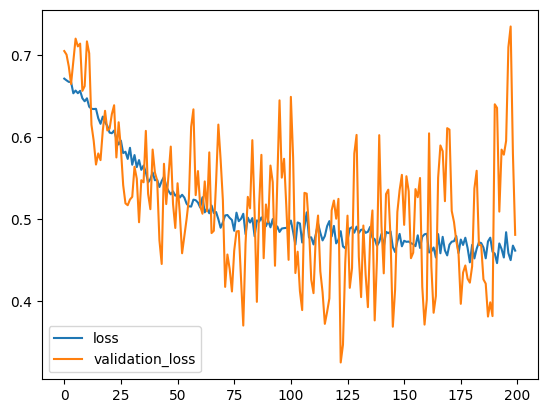

In [20]:
# Let's take a look at our loss (which should be smooth), against our noisy/small validation set.
pd.concat(epochs, axis=1).transpose().plot()

In [21]:
# We can access the trained model by calling its artifact method. 
model = TitanicTrain.model.artifact()
model

Sequential(
  (0): Linear(in_features=10, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
  (3): Sigmoid()
)